**Step 1: Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, PowerTransformer
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

**Step 2: Load Data and Checking info.**

In [2]:
df = pd.read_csv("/kaggle/input/habermans-survival-data-set/haberman.csv", header=None, names=["age", "operation_year", "lymph_nodes", "status"])
df.head()

,age,operation_year,lymph_nodes,status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [3]:
df.columns

Index(['age', 'operation_year', 'lymph_nodes', 'status'], dtype='object')

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             306 non-null    int64
 1   operation_year  306 non-null    int64
 2   lymph_nodes     306 non-null    int64
 3   status          306 non-null    int64
dtypes: int64(4)
memory usage: 9.7 KB


,age,operation_year,lymph_nodes,status
count,306.000000,306.000000,306.000000,306.000000
mean,52.457516,62.852941,4.026144,1.264706
std,10.803452,3.249405,7.189654,0.441899
min,30.000000,58.000000,0.000000,1.000000
25%,44.000000,60.000000,0.000000,1.000000
50%,52.000000,63.000000,1.000000,1.000000
75%,60.750000,65.750000,4.000000,2.000000
max,83.000000,69.000000,52.000000,2.000000


In [5]:
print(df["status"].value_counts())

status
1    225
2     81
Name: count, dtype: int64


In [6]:
df.isnull().sum()

age               0
operation_year    0
lymph_nodes       0
status            0
dtype: int64

**Step 3: Exploratory Data Analysis (EDA)**

**Pairplot (Scatterplot matrix colored by class)**

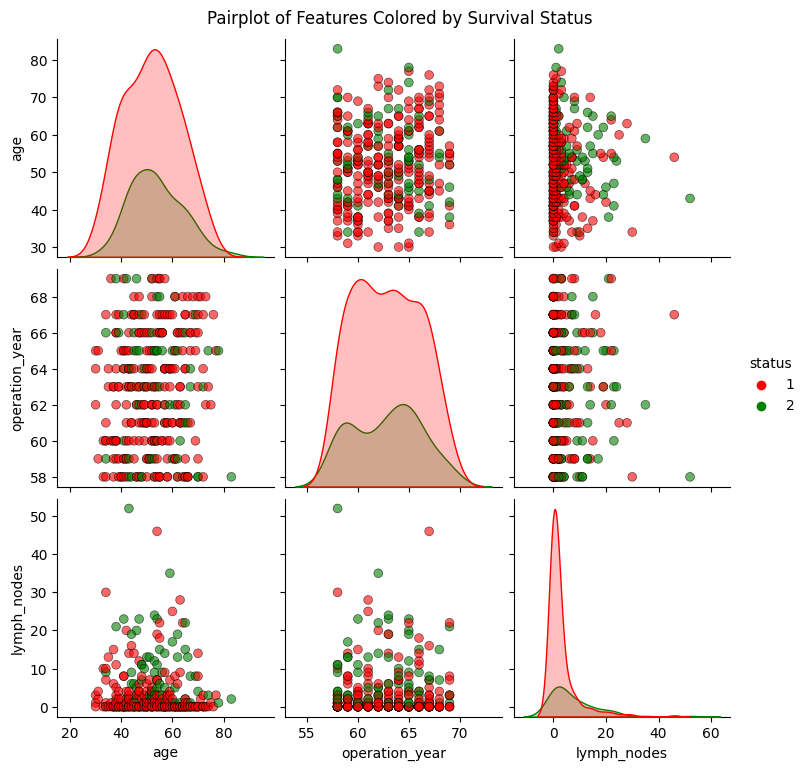

In [7]:
sns.pairplot(df, hue="status", palette=["red", "green"], diag_kind="kde",
             plot_kws={'alpha':0.6, 's':40, 'edgecolor':'k'})
plt.suptitle("Pairplot of Features Colored by Survival Status", y=1.02)
plt.show()

**Countplot of target classes (Survival status distribution)**

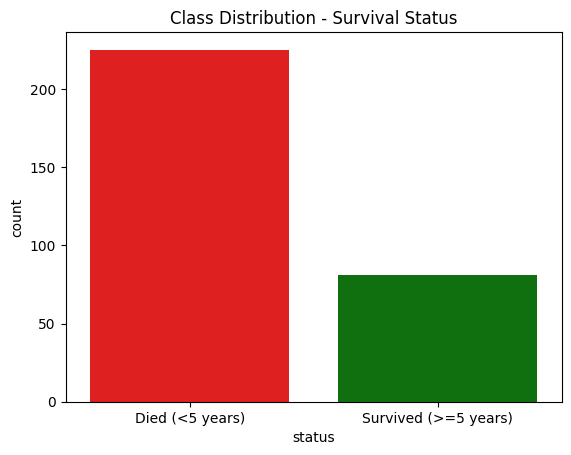

In [8]:
sns.countplot(x="status", data=df, palette=["red", "green"])
plt.xticks(ticks=[0, 1], labels=["Died (<5 years)", "Survived (>=5 years)"])
plt.title("Class Distribution - Survival Status")
plt.show()

**Boxplots of features grouped by survival status (to see distributions)**

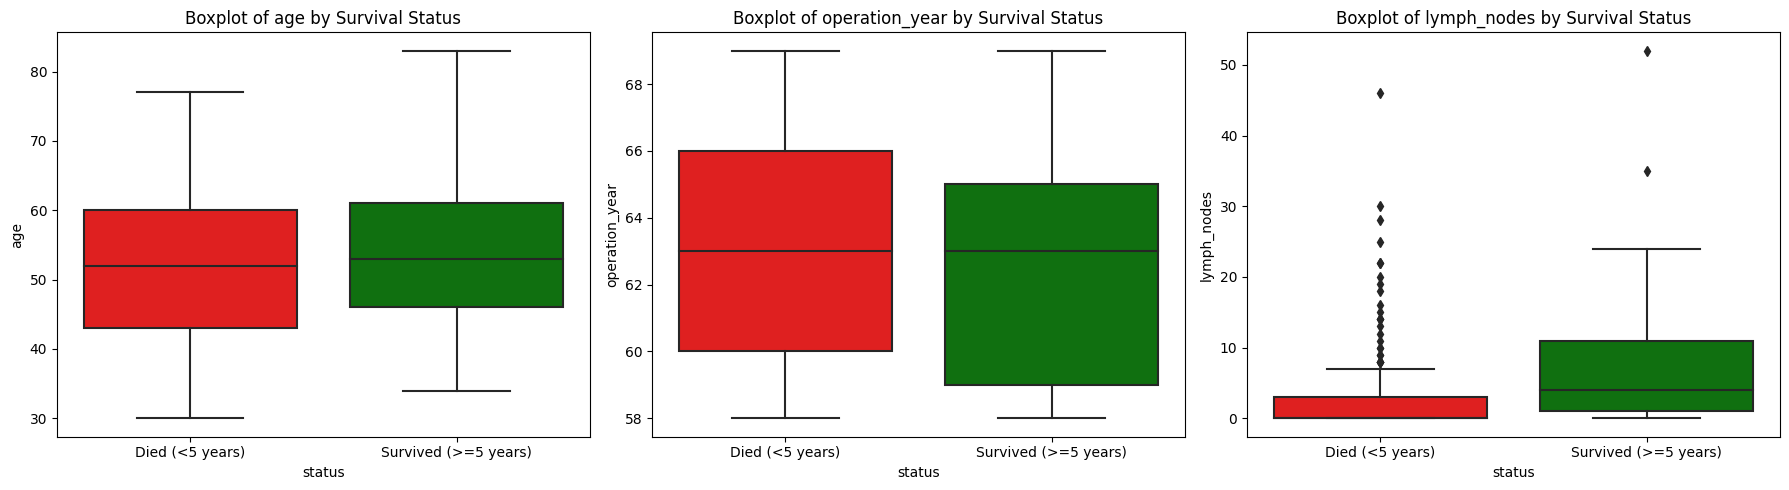

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
features = ["age", "operation_year", "lymph_nodes"]

for i, feature in enumerate(features):
    sns.boxplot(x="status", y=feature, data=df, ax=axes[i], palette=["red", "green"])
    axes[i].set_xticklabels(["Died (<5 years)", "Survived (>=5 years)"])
    axes[i].set_title(f"Boxplot of {feature} by Survival Status")

plt.tight_layout()
plt.show()


**KDE (Kernel Density Estimation) plots for each feature by class**

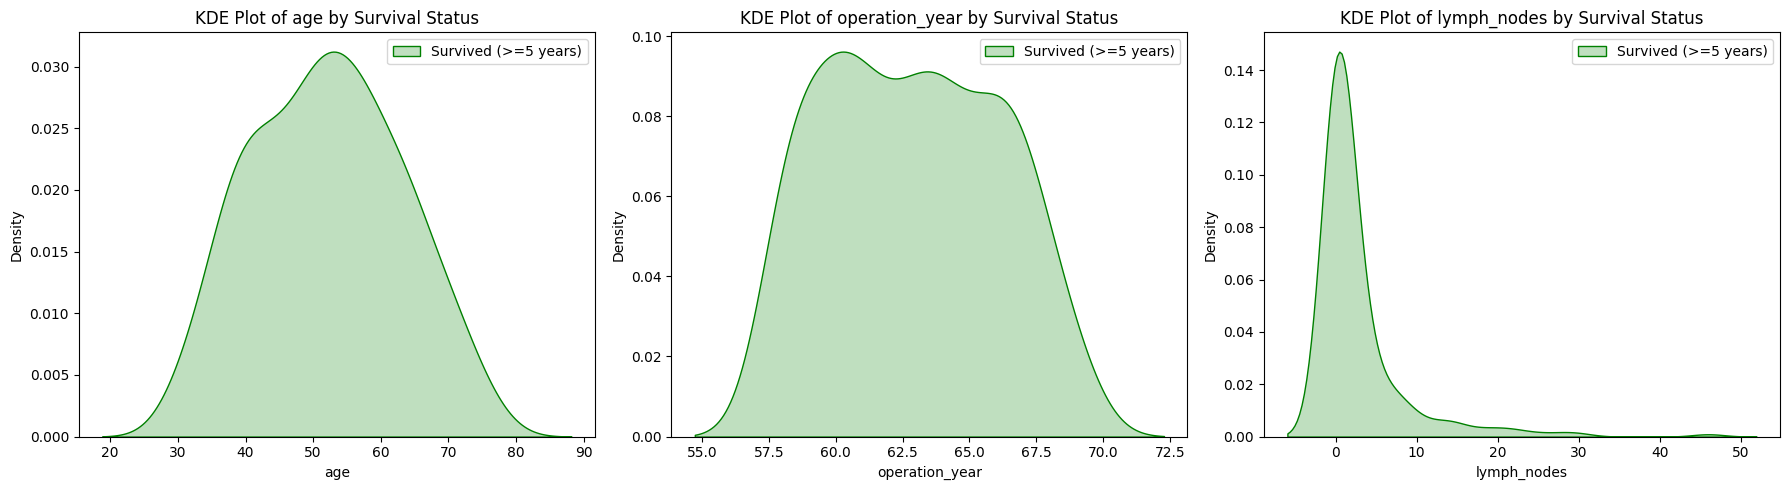

In [10]:
plt.figure(figsize=(18, 5))
for i, feature in enumerate(features):
    plt.subplot(1, 3, i + 1)
    sns.kdeplot(df.loc[df['status'] == 0, feature], label="Died (<5 years)", shade=True, color="red")
    sns.kdeplot(df.loc[df['status'] == 1, feature], label="Survived (>=5 years)", shade=True, color="green")
    plt.title(f"KDE Plot of {feature} by Survival Status")
    plt.legend()

plt.tight_layout()
plt.show()

**Correlation Heatmap**

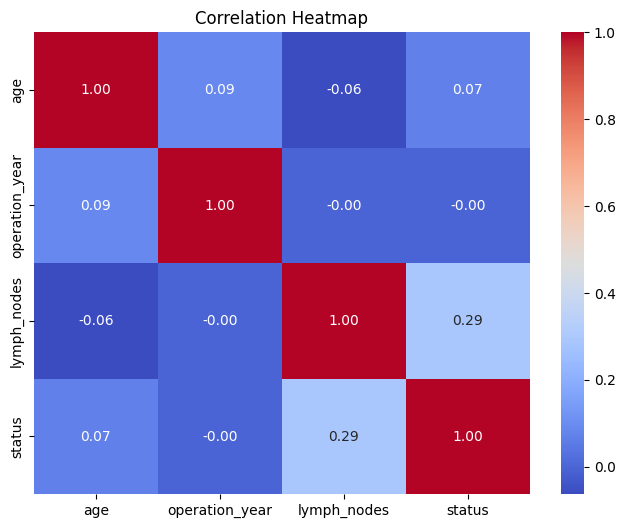

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

**Step 4: Data preprocessing and Train-test split**

In [12]:
# Convert target to binary: 1 (survived 5+ years), 0 (died within 5 years)
df["status"] = df["status"].apply(lambda x: 1 if x == 1 else 0)

In [13]:
# z_scores = np.abs(stats.zscore(df.drop("status", axis=1)))
# df = df[(z_scores < 3).all(axis=1)]

# Feature transformation (optional but useful for skewed data)
# pt = PowerTransformer(method='yeo-johnson')
# X_transformed = pt.fit_transform(df.drop("status", axis=1))


In [14]:
X = df.drop("status", axis=1)
y = df["status"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

**Step 5: Define Models**

In [16]:
models_untuned = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier()
}

**Step 6: Train and Evaluation without Tuning**

In [17]:
results_untuned = {}
roc_curves = {}

for name, model in models_untuned.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    results_untuned[name] = {
        "model": model,
        "accuracy": acc,
        "confusion": confusion_matrix(y_test, y_pred),
        "report": classification_report(y_test, y_pred, output_dict=True),
    }
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curves[name] = (fpr, tpr, auc(fpr, tpr))

print("Untuned Model Accuracies:")
for name, result in results_untuned.items():
    print(f"{name}: {result['accuracy']:.4f}")

Untuned Model Accuracies:
Logistic Regression: 0.7419
SVM: 0.7258
Decision Tree: 0.5645
Random Forest: 0.6452
Gradient Boosting: 0.6774
AdaBoost: 0.7258
Naive Bayes: 0.7581
KNN: 0.6774


In [18]:
best_untuned_name = max(results_untuned, key=lambda name: results_untuned[name]['accuracy'])
best_untuned_model = results_untuned[best_untuned_name]["model"]

print(f"\nBest Untuned Model: {best_untuned_name}")
print(f"Accuracy: {results_untuned[best_untuned_name]['accuracy']:.4f}")


Best Untuned Model: Naive Bayes
Accuracy: 0.7581


**Confusion Matrix and Classification Report for untuned best model**


Confusion Matrix - Naive Bayes (Untuned)


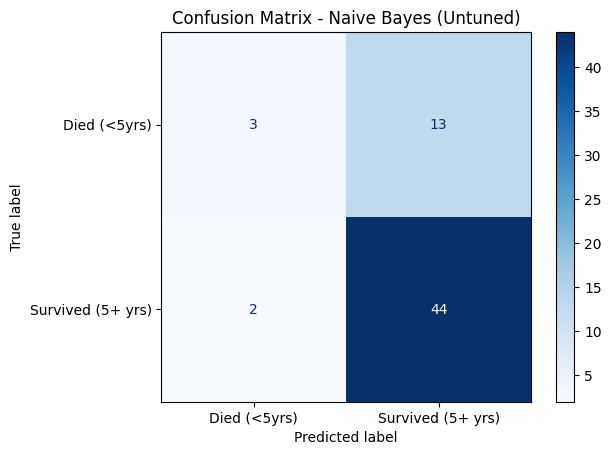

In [19]:
best_cm = results_untuned[best_untuned_name]["confusion"]
print(f"\nConfusion Matrix - {best_untuned_name} (Untuned)")
#print(best_cm)

disp = ConfusionMatrixDisplay(confusion_matrix=best_cm, display_labels=["Died (<5yrs)", "Survived (5+ yrs)"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - {best_untuned_name} (Untuned)")
plt.show()

In [20]:
print(f"\nClassification Report - {best_untuned_name} (Untuned)")
print(classification_report(y_test, best_untuned_model.predict(X_test)))


Classification Report - Naive Bayes (Untuned)
              precision    recall  f1-score   support

           0       0.60      0.19      0.29        16
           1       0.77      0.96      0.85        46

    accuracy                           0.76        62
   macro avg       0.69      0.57      0.57        62
weighted avg       0.73      0.76      0.71        62



**ROC Curves for all untuned models**

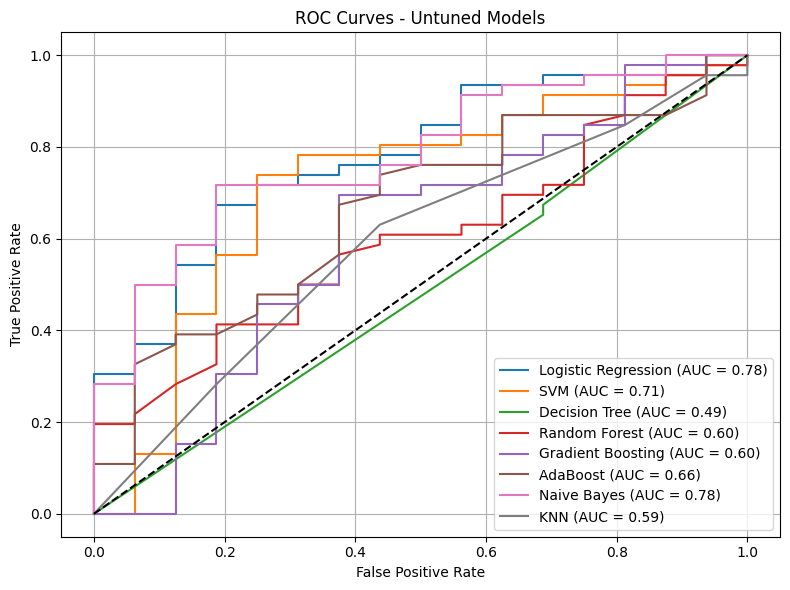

In [21]:
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Untuned Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Step 7: Define parameter grids**

In [22]:
param_grids = {
    "Logistic Regression": {"C": [0.1, 1, 10]},
    "SVM": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]},
    "Decision Tree": {"max_depth": [2, 4, 6, None]},
    "Random Forest": {"n_estimators": [50, 100], "max_depth": [3, 5, None]},
    "Gradient Boosting": {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1]},
    "AdaBoost": {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1]},
    "Naive Bayes": {},  # No tuning
    "KNN": {"n_neighbors": [3, 5, 7]}
}

**Step 8: Train and Evaluation with Tuning**

In [23]:
results_tuned = {}
roc_curves_tuned = {}

for name in models_untuned.keys():
    model = models_untuned[name]

    # Perform GridSearchCV if parameters are defined
    if param_grids[name]:
        grid = GridSearchCV(model, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
    else:
        best_model = model.fit(X_train, y_train)

    # Predictions
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # ROC curve calculation
    if hasattr(best_model, "predict_proba"):
        y_score = best_model.predict_proba(X_test)[:, 1]
    elif hasattr(best_model, "decision_function"):
        y_score = best_model.decision_function(X_test)
    else:
        y_score = None  # Skip ROC for this model

    if y_score is not None:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        roc_curves_tuned[name] = (fpr, tpr, roc_auc)

    # Store results
    results_tuned[name] = {
        "model": best_model,
        "accuracy": acc,
        "confusion": confusion_matrix(y_test, y_pred),
        "report": classification_report(y_test, y_pred, output_dict=True)
    }

print("Tuned Model Accuracies:")
for name, result in results_tuned.items():
    print(f"{name}: {result['accuracy']:.4f}")

Tuned Model Accuracies:
Logistic Regression: 0.7419
SVM: 0.7419
Decision Tree: 0.7581
Random Forest: 0.7581
Gradient Boosting: 0.7258
AdaBoost: 0.7258
Naive Bayes: 0.7581
KNN: 0.7419


In [24]:
best_tuned_name = max(results_tuned, key=lambda name: results_tuned[name]['accuracy'])
best_tuned_model = results_tuned[best_tuned_name]["model"]

print(f"\nBest Tuned Model: {best_tuned_name}")
print(f"Accuracy: {results_tuned[best_tuned_name]['accuracy']:.4f}")


Best Tuned Model: Decision Tree
Accuracy: 0.7581


**Confusion Matrix and Classification Report for tuned best model**


Confusion Matrix - Decision Tree (Tuned)


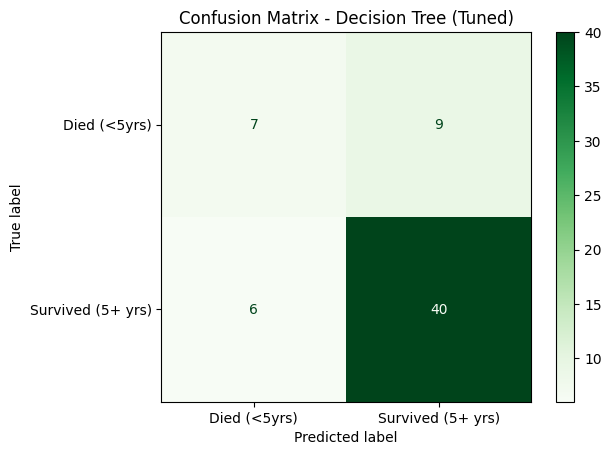

In [25]:
best_cm = results_tuned[best_tuned_name]["confusion"]
print(f"\nConfusion Matrix - {best_tuned_name} (Tuned)")
#print(best_cm)

disp = ConfusionMatrixDisplay(confusion_matrix=best_cm, display_labels=["Died (<5yrs)", "Survived (5+ yrs)"])
disp.plot(cmap="Greens")
plt.title(f"Confusion Matrix - {best_tuned_name} (Tuned)")
plt.show()

In [26]:
print(f"\nClassification Report - {best_tuned_name} (Tuned)")
print(classification_report(y_test, best_tuned_model.predict(X_test)))


Classification Report - Decision Tree (Tuned)
              precision    recall  f1-score   support

           0       0.54      0.44      0.48        16
           1       0.82      0.87      0.84        46

    accuracy                           0.76        62
   macro avg       0.68      0.65      0.66        62
weighted avg       0.74      0.76      0.75        62



**ROC Curves for all tuned models**

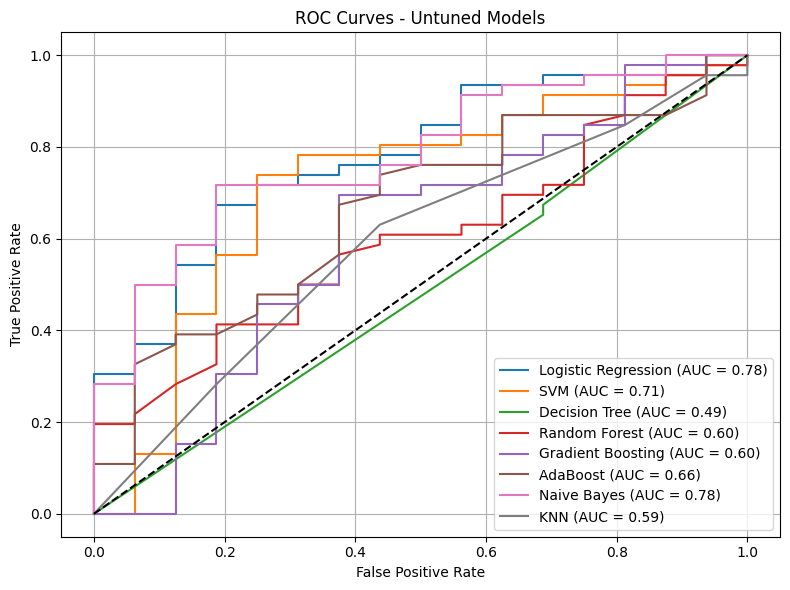

In [27]:
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Untuned Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Step 9: Models Comparison**

In [28]:
comparison_df = pd.DataFrame({
    "Model": results_untuned.keys(),
    "Accuracy (Untuned)": [results_untuned[m]["accuracy"] for m in results_untuned],
    "Accuracy (Tuned)": [results_tuned[m]["accuracy"] for m in results_tuned]
}).sort_values(by="Accuracy (Tuned)", ascending=False)

print(comparison_df)

                 Model  Accuracy (Untuned)  Accuracy (Tuned)
2        Decision Tree            0.564516          0.758065
3        Random Forest            0.645161          0.758065
6          Naive Bayes            0.758065          0.758065
0  Logistic Regression            0.741935          0.741935
1                  SVM            0.725806          0.741935
7                  KNN            0.677419          0.741935
4    Gradient Boosting            0.677419          0.725806
5             AdaBoost            0.725806          0.725806


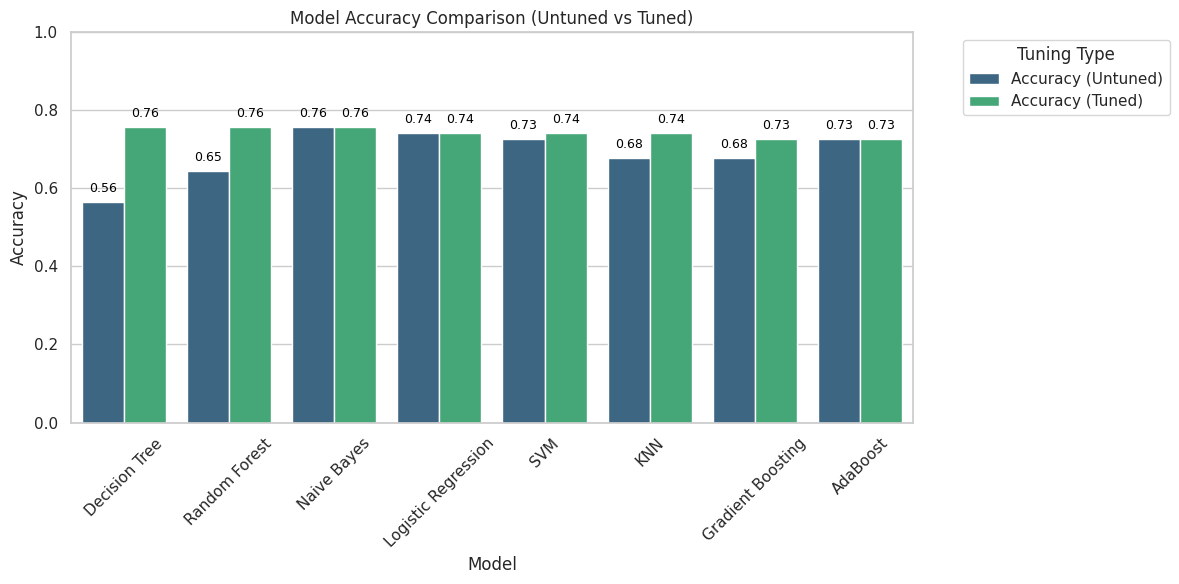

In [29]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

melted_df = comparison_df.melt(id_vars="Model", var_name="Tuning", value_name="Accuracy")

bar = sns.barplot(
    data=melted_df,
    x="Model", y="Accuracy", hue="Tuning", palette="viridis"
)
for p in bar.patches:
    height = p.get_height()
    bar.annotate(
        f'{height:.2f}', 
        (p.get_x() + p.get_width() / 2., height),
        ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 5),
        textcoords='offset points'
    )

plt.legend(title="Tuning Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Model Accuracy Comparison (Untuned vs Tuned)")
plt.xticks(rotation=45)
plt.ylim(0, 1) 
plt.tight_layout()
plt.show()

**Step 10: Prediction**

In [30]:
untuned_accuracies = {name: result['accuracy'] for name, result in results_untuned.items()}
best_untuned_name = max(untuned_accuracies, key=untuned_accuracies.get)
best_untuned_model = results_untuned[best_untuned_name]["model"]

tuned_accuracies = {name: result['accuracy'] for name, result in results_tuned.items()}
best_tuned_name = max(tuned_accuracies, key=tuned_accuracies.get)
best_tuned_model = results_tuned[best_tuned_name]["model"]

sample = X_test[:10]
true_vals = y_test.iloc[:10]
pred_untuned = best_untuned_model.predict(sample)
pred_tuned = best_tuned_model.predict(sample)

prediction_df = pd.DataFrame({
    'Actual': true_vals.values,
    f'{best_untuned_name} (Untuned)': pred_untuned,
    f'{best_tuned_name} (Tuned)': pred_tuned
})

print("Prediction Comparison:\n")
print(prediction_df)

Prediction Comparison:

   Actual  Naive Bayes (Untuned)  Decision Tree (Tuned)
0       1                      1                      1
1       0                      1                      0
2       1                      1                      1
3       1                      1                      1
4       0                      0                      1
5       1                      1                      1
6       0                      1                      1
7       1                      1                      1
8       0                      1                      1
9       1                      0                      0
